Adapted from [this](https://github.com/waddell/urban-informatics-and-visualization/blob/master/Other%20Materials/19%20-%20Working-With-PUMS-Data.ipynb) notebook by Aksel Olsen

In [236]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [2]:
pums_h = pd.read_csv("/Users/max/Downloads/csv_hca(2)/ss12hca.csv")

In [3]:
pums_h.index=pums_h.SERIALNO

In [4]:
pums_p = pd.read_csv("/Users/max/Downloads/csv_pca(1)/ss12pca.csv")

In [5]:
print("there are %s observations of %s variables in the housing table " %(pums_h.shape[0],pums_h.shape[1]))
print("there are %s observations of %s variables in the population table " %(pums_p.shape[0],pums_p.shape[1]))

there are 153115 observations of 206 variables in the housing table 
there are 368047 observations of 286 variables in the population table 


In [6]:
bayareafips ={'001':'Alameda', '013':'Contra Costa', '041':'Marin', '055':'Napa', '075':'San Francisco', '081':'San Mateo', '085':'Santa Clara', '095':'Sonoma', '097':'Solano'}
bayareafips.keys()

dict_keys(['001', '013', '041', '055', '075', '081', '085', '095', '097'])

In [7]:
sfPUMAS = [k for k in range(7501,7508)]
sfPUMAS

[7501, 7502, 7503, 7504, 7505, 7506, 7507]

In [8]:
pums_p=pums_p[pums_p.PUMA.isin(sfPUMAS)]
pums_p.shape

(7311, 286)

In [9]:
pums_h=pums_h[pums_h.PUMA.isin(sfPUMAS)]
pums_h.shape

(3586, 206)

In [10]:
pums_p.groupby(['PUMA'])['PWGTP'].agg(['size'])

,size
PUMA,
7501,1231
7502,896
7503,971
7504,955
7505,969
7506,1063
7507,1226


In [11]:
sf_pop = pums_p.PWGTP.sum()
sf_pop

824855

In [12]:
pums_h.columns

Index(['RT', 'SERIALNO', 'DIVISION', 'PUMA', 'REGION', 'ST', 'ADJHSG',
       'ADJINC', 'WGTP', 'NP',
       ...
       'wgtp71', 'wgtp72', 'wgtp73', 'wgtp74', 'wgtp75', 'wgtp76', 'wgtp77',
       'wgtp78', 'wgtp79', 'wgtp80'],
      dtype='object', length=206)

In [13]:
pums_h['YBL'].value_counts()

1.0     1617
3.0      366
2.0      366
4.0      278
5.0      214
6.0      152
7.0      113
8.0       89
11.0      27
9.0       24
13.0      22
12.0      12
14.0      12
10.0      10
15.0       6
16.0       1
Name: YBL, dtype: int64

In [310]:
pums_h['YBL'].value_counts()

1.0     1617
3.0      366
2.0      366
4.0      278
5.0      214
6.0      152
7.0      113
8.0       89
11.0      27
9.0       24
13.0      22
12.0      12
14.0      12
10.0      10
15.0       6
16.0       1
Name: YBL, dtype: int64

In [311]:
# we skip the blank category here--Ideally fix, but currently most vars are loaded as integers, so 'bb' won't work here

# RACE
# note that these are not actually verbatim categories from the code book. Instead, this collapses categories.
codesrace = {
    1: "White",
    2: "Black",
    3: "Other",
    4: "Other",
    5: "Other",
    6: "Asian",
    7: "Other",
    8: "Other",
    9: "Two + Races"
}

# TENURE
codesten={
    1.0: "Owned with mortgage or loan (include home equity loans)",
    2.0: "Owned free and clear",
    3.0: "Rented",
    4.0: "Occupied without payment of rent"
}

## YEAR BUILT
codeybl={
    1.0: "1939 or earlier",
    2.0: "1940 to 1949",
    3.0: "1950 to 1959",
    4.0: "1960 to 1969",
    5.0: "1970 to 1979",
    6.0: "1980 to 1989",
    7.0: "1990 to 1999",
    8.0: "2000 to 2004",
    9.0: "2005",
    10.0: "2006",
    11.0: "2007",
    12.0: "2008",
    13.0: "2009",
    14.0: "2010",
    15.0: "2011",
    16.0: "2012"
}

# YEAR MOVED INTO UNIT
codemovein={
    1: "12 months or less",
    2: "13 to 23 months",
    3: "2 to 4 years",
    4: "5 to 9 years",
    5: "10 to 19 years",
    6: "20 to 29 years",
    7: "30 years or more",
}

# num units
codebldg={
    1.0: "Mobile home or trailer",
    2.0: "One-family house detached",
    3.0: "One-family house attached",
    4.0: "2 Apartments",
    5.0: "3-4 Apartments",
    6.0: "5-9 Apartments",
    7.0: "10-19 Apartments",
    8.0: "20-49 Apartments",
    9.0: "50 or more apartments",
    10.0: "Boat, RV, van, etc."
}

In [312]:
pums_p['RAC1P_l'] = pums_p['RAC1P'].map(codesrace)
pums_p['RAC1P_l'].value_counts(dropna=False)

White          3651
Asian          2481
Black           406
Other           405
Two + Races     368
Name: RAC1P_l, dtype: int64

In [313]:
pums_h['MV_l'] = pums_h['MV'].map(codemovein)
pums_h['MV_l'].value_counts(dropna=False)

5 to 9 years         673
2 to 4 years         592
10 to 19 years       577
13 to 23 months      420
30 years or more     406
12 months or less    402
20 to 29 years       365
NaN                  151
Name: MV_l, dtype: int64

In [314]:
pums_h['TEN_l'] = pums_h['TEN'].map(codesten)
pums_h['TEN_l'].value_counts(dropna=False)

Rented                                                     1784
Owned with mortgage or loan (include home equity loans)     935
NaN                                                         428
Owned free and clear                                        396
Occupied without payment of rent                             43
Name: TEN_l, dtype: int64

In [315]:
pums_h['YBL_l'] = pums_h['YBL'].map(codeybl)
pums_h['YBL_l'].value_counts(dropna=False)

1939 or earlier    1617
1950 to 1959        366
1940 to 1949        366
1960 to 1969        278
NaN                 277
1970 to 1979        214
1980 to 1989        152
1990 to 1999        113
2000 to 2004         89
2007                 27
2005                 24
2009                 22
2010                 12
2008                 12
2006                 10
2011                  6
2012                  1
Name: YBL_l, dtype: int64

In [316]:
pums_h['TEN_l'].value_counts(dropna=False)

Rented                                                     1784
Owned with mortgage or loan (include home equity loans)     935
NaN                                                         428
Owned free and clear                                        396
Occupied without payment of rent                             43
Name: TEN_l, dtype: int64

In [317]:
pums_h_rent = pums_h[pums_h['TEN_l'] == 'Rented'].copy()

In [318]:
pums_h['YBL_l'].unique()

array(['1980 to 1989', '1940 to 1949', '1939 or earlier', '1960 to 1969',
       '2005', '1990 to 1999', '1970 to 1979', '2000 to 2004', nan,
       '2007', '1950 to 1959', '2009', '2010', '2011', '2008', '2006',
       '2012'], dtype=object)

In [319]:
pums_h_rent.WGTP.sum()

216427

In [320]:
pums_h_rent['rent_control'] = (pums_h_rent['YBL'] <= 5) & (pums_h_rent['BLD'] >= 4) & (pums_h_rent['BLD'] < 10)

In [321]:
rc_totals = hsg_by_bltyr.groupby('rent_control')[['WGTP']].sum()

In [322]:
rc_totals = rc_totals.rename(columns={'WGTP':'total'}).reset_index()

Text(0, 0.5, '% Pop. by Rent Control Status')

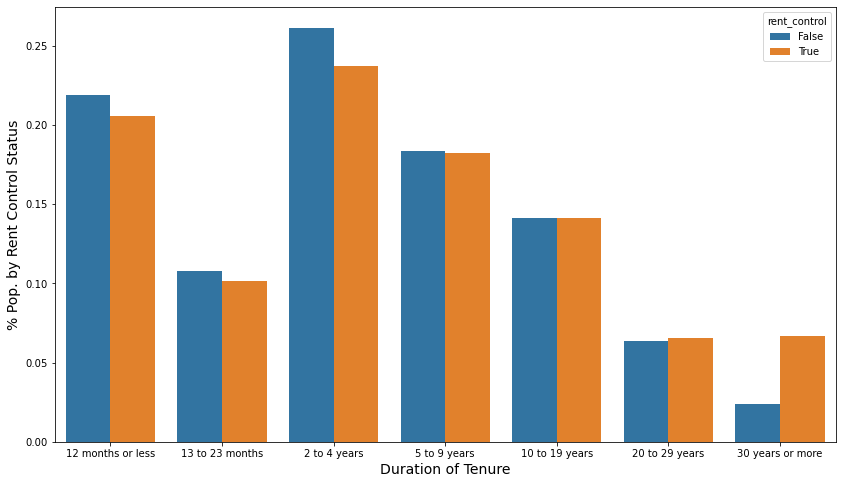

In [323]:
fig, ax = plt.subplots(figsize=(14,8))
mv_by_rc = pums_h_rent[['rent_control','MV_l','WGTP']].groupby(['rent_control','MV_l']).sum()
mv_by_rc = mv_by_rc.reset_index()
mv_by_rc = pd.merge(mv_by_rc, rc_totals, on='rent_control')
mv_by_rc['% pop by rent control status'] = mv_by_rc['WGTP'] / mv_by_rc['total']
sns.barplot(
    x='MV_l', y='% pop by rent control status',
    data=mv_by_rc, hue='rent_control',
    order=['12 months or less', '13 to 23 months', '2 to 4 years', '5 to 9 years', '10 to 19 years', '20 to 29 years', '30 years or more']
)
ax.set_xlabel("Duration of Tenure", fontsize=14)
ax.set_ylabel("% Pop. by Rent Control Status", fontsize=14)

In [261]:
## function to be passed by groupby.apply to returned weighted estimate--no standard errors provided
def weighted_mean(frame, var, weight):
    """
    Takes ungrouped observations, splits into groups, applies the logic below, and combines groups into one table. 
    Needs the numeric variable (var) as well as the group by varible (group, as a list) to be passed. Basically
    a weighted mean by categorical group.
    """
    
    ## A: calculates the weighted value of the variable at the level of each observation
    weighted_x = frame[weight] * frame[var]  

    try:
        # sums value for the group and divides by weighted sum of records, returning
        # one value for each group. 
        estimate = weighted_x.sum() / frame[weight].sum()
    
    except ZeroDivisionError:
        estimate = 0

    return pd.DataFrame(data={var:[estimate]})

## function to be passed by groupby.apply to returned weighted estimate--no standard errors provided
def weighted_SE(frame, var, weights):

    ## A: calculates the weigted value of var x at the level of each observation
    wcol = [] # weight collection
    primary = [] # holder of the main estimate
    
    ## calculate 81 estimates (the last 80 being replicates)
    for w in weights:
        weighted_x = frame[w] * frame[var]  
        repl_estimate = weighted_x.sum() / frame[w].sum()
        wcol.append(repl_estimate)
    
    primary.append(wcol[0])
    wcol = wcol[1:]        
    squared_difference = 0

    primaryWeightSum = pd.Series(primary).sum()
    replicateWeightsSum = pd.Series(wcol).sum() 
    
    ## loop through each rep weight column, calculate sq difference with main weight     
    for col in wcol:
        squared_difference = squared_difference + (col - primary[0])**2

    # formula derived from: https://www2.census.gov/programs-surveys/acs/tech_docs/pums/accuracy/2012AccuracyPUMS.pdf
    variance =(4 / 80.) * squared_difference
    standard_error = (variance)**.5
    
    return pd.DataFrame(data={var:[primaryWeightSum], 'se':standard_error})

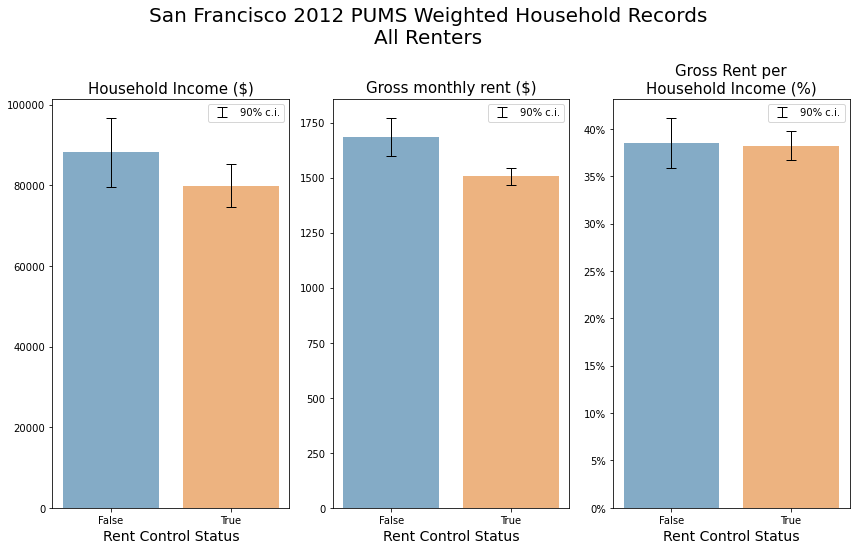

In [367]:
fig, axarr = plt.subplots(1, 3, figsize=(12, 8))
wgt='WGTP'
grp='rent_control'
value_to_label = {
    'HINCP': 'Household Income ($)', 'GRPIP': 'Gross Rent per\nHousehold Income (%)', 'RNTP': 'Monthly Rent ($)',
    'GRNTP': 'Gross monthly rent ($)'
}
for i, value in enumerate(['HINCP', 'GRNTP', 'GRPIP', ]):
    ax = axarr[i]
    wgt_mean = pums_h_rent[[wgt, value, grp]].groupby(grp).apply(weighted_mean, value, wgt).reset_index()
    sns.barplot(data=wgt_mean, x='rent_control', y=value, ax=ax, alpha=0.6)
    if value == 'GRPIP':
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    ax.set_xlabel("Rent Control Status", fontsize=14)
    ax.set_ylabel("")
    ax.set_title(value_to_label[value], fontsize=15)

    wgt_se = ['WGTP'] + pums_h.filter(like='wgtp', axis=1).columns.tolist()
    yerr = pums_h_rent[wgt_se + [value, grp]].groupby(grp).apply(weighted_SE, value, wgt_se)['se'].values
    ci_90 = yerr * 1.645
    ax.errorbar(
        x=[0, 1],y=wgt_mean[value], yerr=ci_90, fmt='none', c='k', elinewidth=1, capsize=5,
        label='90% c.i.'
    )
    ax.legend()
    
fig.suptitle("San Francisco 2012 PUMS Weighted Household Records\nAll Renters", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.9])

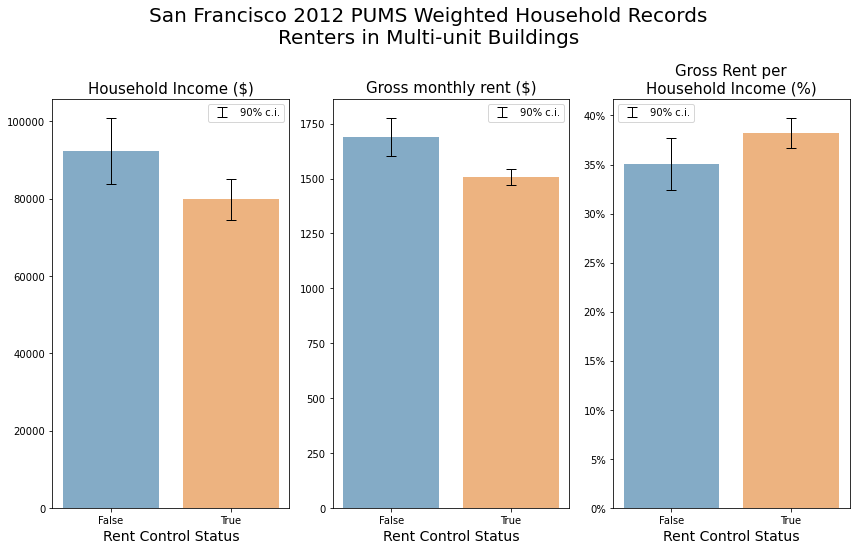

In [368]:
fig, axarr = plt.subplots(1, 3, figsize=(12, 8))
wgt='WGTP'
grp='rent_control'
value_to_label = {
    'HINCP': 'Household Income ($)', 'GRPIP': 'Gross Rent per\nHousehold Income (%)', 'RNTP': 'Monthly Rent ($)',
    'GRNTP': 'Gross monthly rent ($)'
}
for i, value in enumerate(['HINCP', 'GRNTP', 'GRPIP', ]):
    ax = axarr[i]
    wgt_mean = pums_h_rent.loc[(pums_h_rent['BLD'] >= 4) & (pums_h_rent['BLD'] < 10), [wgt, value, grp]].groupby(grp).apply(weighted_mean, value, wgt).reset_index()
    sns.barplot(data=wgt_mean, x='rent_control', y=value, ax=ax, alpha=0.6)
    if value == 'GRPIP':
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    ax.set_xlabel("Rent Control Status", fontsize=14)
    ax.set_ylabel("")
    ax.set_title(value_to_label[value], fontsize=15)

    wgt_se = ['WGTP'] + pums_h.filter(like='wgtp', axis=1).columns.tolist()
    yerr = pums_h_rent[wgt_se + [value, grp]].groupby(grp).apply(weighted_SE, value, wgt_se)['se'].values
    ci_90 = yerr * 1.645
    ax.errorbar(
        x=[0, 1],y=wgt_mean[value], yerr=ci_90, fmt='none', c='k', elinewidth=1, capsize=5,
        label='90% c.i.'
    )
    ax.legend()
    
fig.suptitle("San Francisco 2012 PUMS Weighted Household Records\nRenters in Multi-unit Buildings", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.9])

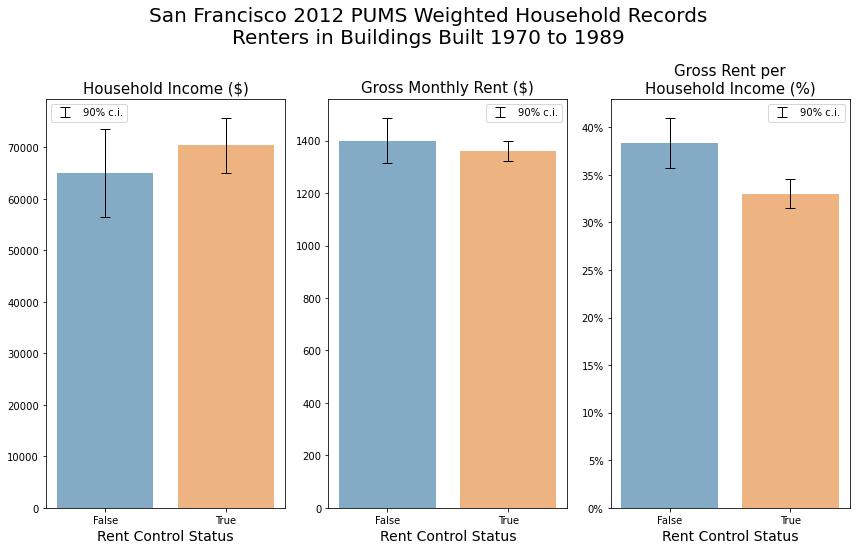

In [369]:
fig, axarr = plt.subplots(1, 3, figsize=(12, 8))
wgt='WGTP'
grp='rent_control'
value_to_label = {'HINCP': 'Household Income ($)', 'GRPIP': 'Gross Rent per\nHousehold Income (%)', 'GRNTP': 'Gross Monthly Rent ($)'}
for i, value in enumerate(['HINCP', 'GRNTP', 'GRPIP']):
    ax = axarr[i]
    wgt_mean = pums_h_rent.loc[pums_h_rent['YBL'].isin([5,6]), [wgt, value, grp]].groupby(grp).apply(weighted_mean, value, wgt).reset_index()
    sns.barplot(data=wgt_mean, x='rent_control', y=value, ax=ax, alpha=0.6)
    if value == 'GRPIP':
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    ax.set_xlabel("Rent Control Status", fontsize=14)
    ax.set_ylabel("")
    ax.set_title(value_to_label[value], fontsize=15)

    wgt_se = ['WGTP'] + pums_h.filter(like='wgtp', axis=1).columns.tolist()
    yerr = pums_h_rent[wgt_se + [value, grp]].groupby(grp).apply(weighted_SE, value, wgt_se)['se'].values
    ci_90 = yerr * 1.645
    ax.errorbar(
        x=[0, 1],y=wgt_mean[value], yerr=ci_90, fmt='none', c='k', elinewidth=1, capsize=5,
        label='90% c.i.'
    )
    ax.legend()
    
fig.suptitle("San Francisco 2012 PUMS Weighted Household Records\nRenters in Buildings Built 1970 to 1989", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.9])

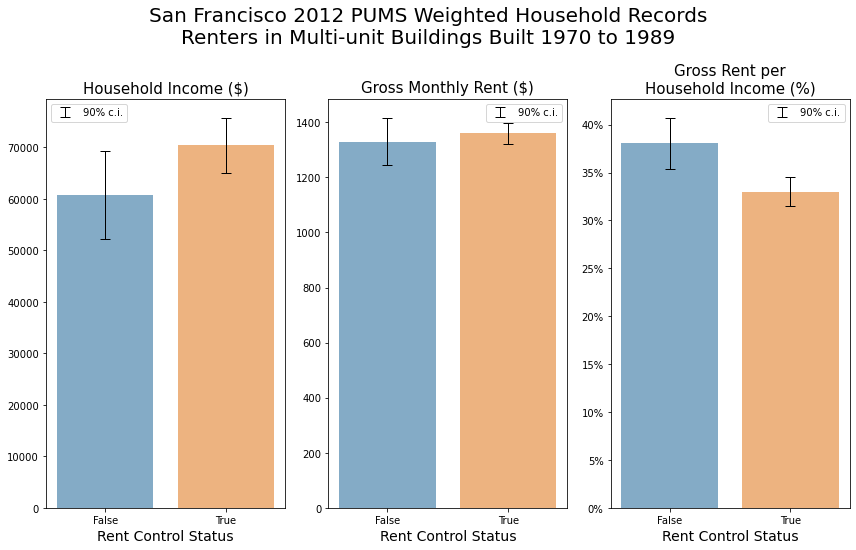

In [370]:
fig, axarr = plt.subplots(1, 3, figsize=(12, 8))
wgt='WGTP'
grp='rent_control'
value_to_label = {'HINCP': 'Household Income ($)', 'GRPIP': 'Gross Rent per\nHousehold Income (%)', 'GRNTP': 'Gross Monthly Rent ($)'}
for i, value in enumerate(['HINCP', 'GRNTP', 'GRPIP']):
    ax = axarr[i]
    wgt_mean = pums_h_rent.loc[pums_h_rent['YBL'].isin([5,6]) & (pums_h_rent['BLD'] >= 4) & (pums_h_rent['BLD'] < 10), [wgt, value, grp]].groupby(grp).apply(weighted_mean, value, wgt).reset_index()
    sns.barplot(data=wgt_mean, x='rent_control', y=value, ax=ax, alpha=0.6)
    if value == 'GRPIP':
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    ax.set_xlabel("Rent Control Status", fontsize=14)
    ax.set_ylabel("")
    ax.set_title(value_to_label[value], fontsize=15)

    wgt_se = ['WGTP'] + pums_h.filter(like='wgtp', axis=1).columns.tolist()
    yerr = pums_h_rent[wgt_se + [value, grp]].groupby(grp).apply(weighted_SE, value, wgt_se)['se'].values
    ci_90 = yerr * 1.645
    ax.errorbar(
        x=[0, 1],y=wgt_mean[value], yerr=ci_90, fmt='none', c='k', elinewidth=1, capsize=5,
        label='90% c.i.'
    )
    ax.legend()
    
fig.suptitle("San Francisco 2012 PUMS Weighted Household Records\nRenters in Multi-unit Buildings Built 1970 to 1989", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.9])

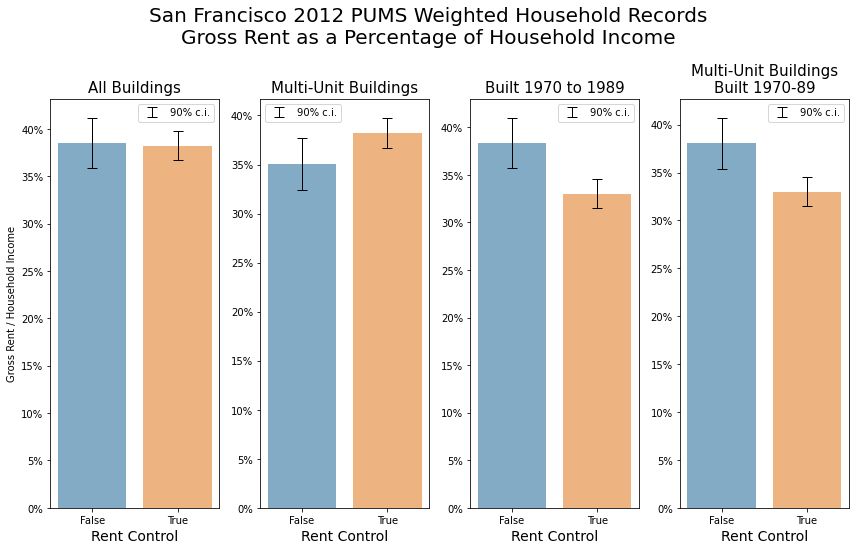

In [383]:
fig, axarr = plt.subplots(1, 4, figsize=(12, 8))
wgt='WGTP'
grp='rent_control'
value_to_label = {'GRPIP': 'Gross Rent per\nHousehold Income (%)'}
mask = None
for i in range(4):
    ax = axarr[i]
    ax.set_ylabel("")
    if i == 0:
        wgt_mean = pums_h_rent[[wgt, value, grp]].groupby(grp).apply(weighted_mean, value, wgt).reset_index()
        ax.set_title("All Buildings", fontsize=15)

    elif i == 1:
        wgt_mean = pums_h_rent.loc[(pums_h_rent['BLD'] >= 4) & (pums_h_rent['BLD'] < 10), [wgt, value, grp]].groupby(grp).apply(weighted_mean, value, wgt).reset_index()
        ax.set_title("Multi-Unit Buildings", fontsize=15)
    elif i == 2:    
        wgt_mean = pums_h_rent.loc[pums_h_rent['YBL'].isin([5,6]), [wgt, value, grp]].groupby(grp).apply(weighted_mean, value, wgt).reset_index()
        ax.set_title("Built 1970 to 1989", fontsize=15)
    else:
        wgt_mean = pums_h_rent.loc[(pums_h_rent['BLD'] >= 4) & (pums_h_rent['BLD'] < 10) & (pums_h_rent['YBL'].isin([5,6])), [wgt, value, grp]].groupby(grp).apply(weighted_mean, value, wgt).reset_index()
        ax.set_title("Multi-Unit Buildings\nBuilt 1970-89", fontsize=15)
    sns.barplot(data=wgt_mean, x='rent_control', y=value, ax=ax, alpha=0.6)

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    ax.set_xlabel("Rent Control", fontsize=14)
    ax.set_ylabel("")
    if i == 0:
        ax.set_ylabel("Gross Rent / Household Income")


    wgt_se = ['WGTP'] + pums_h.filter(like='wgtp', axis=1).columns.tolist()
    yerr = pums_h_rent[wgt_se + [value, grp]].groupby(grp).apply(weighted_SE, value, wgt_se)['se'].values
    ci_90 = yerr * 1.645
    ax.errorbar(
        x=[0, 1],y=wgt_mean[value], yerr=ci_90, fmt='none', c='k', elinewidth=1, capsize=5,
        label='90% c.i.'
    )
    ax.legend()
    
fig.suptitle("San Francisco 2012 PUMS Weighted Household Records\nGross Rent as a Percentage of Household Income", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.9])